In [ ]:
#!pip install -q cirq

In [ ]:
import numpy as np
import math
import cmath
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import load_iris, make_circles
from sklearn.preprocessing import normalize, LabelEncoder, minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.special import logit
import bisect
import queue
import seaborn as sns
import pandas as pd
#from cirq import partial_trace

print(np.__version__)
print(torch.__version__)

1.25.2
2.2.1+cu121


In [ ]:
class dataset(Dataset):
  def __init__(self, x, y):
    if torch.cuda.is_available():
      self.device = "cuda"
    else:
      self.device = "cpu"

    self.x = torch.tensor(x, dtype=torch.complex128, device=self.device)
    self.y = torch.tensor(y, device=self.device)
    self.length = self.x.shape[0]

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

  def __len__(self):
    return self.length

def logits(preds, classes):
  logits = []
  points = []
  range_len = 2 / classes
  # divide [-1, 1] in #classes ranges with #classes + 1 points
  for i in range(classes + 1):
    points.append(-1 + i * range_len)

  #print(points)

  if (classes == 2):
    cls = [-1, 1]

    for p in preds:
      probs = [0.01,] * classes # initialization of probabilities to a low number (not completely zero because logit(0) = -inf)
      dists = [abs(c - p) for c in cls] # distance of prediction from each class

      if dists[0] != dists[1]:
        pred_class = dists.index(min(dists)) # find predicted class
        prob = 1 - dists[pred_class] if dists[pred_class] != 1 else 0.5
        probs[pred_class] = prob if prob != 1 else 0.99 # 0.99 instead of 1 because logit(1) = inf

      #print(probs)
      logits.append(list(logit(probs)))
      #logits.append(probs)
  elif (classes == 3):
    for p in preds:
      probs = [0.01,] * classes # initialization of probabilities to a low number (not completely zero because logit(0) = -inf)
      index = bisect.bisect(points, p)
      pred_class = index - 1 if index < classes else classes - 1 # find predicted class

      if index > len(points) / 2:
        prob = (p - points[index - 1]) / range_len
        prob = prob if prob != 0 else 1 # just for the case that pred = 1
      elif index < len(points) / 2:
        prob = abs(p - points[index - 1]) / range_len
        prob = prob if prob != 0 else 1 # just for the case that pred = -1
      else:
        prob = (points[index] - abs(p)) / points[index]

      probs[pred_class] = prob if prob != 1 else 0.99 # 0.99 instead of 1 because logit(1) = inf

      #print(probs)
      logits.append(list(logit(probs)))
      #logits.append(probs)

  return logits

# partial_trace from google's cirq lib
def partial_trace(tensor, keep_indices):
  ndim = tensor.ndim // 2
  if not all(tensor.shape[i] == tensor.shape[i + ndim] for i in range(ndim)):
        raise ValueError(
            f'Tensors must have shape (d_0,...,d_{{k-1}},d_0,...,'
            f'd_{{k-1}}) but had shape ({tensor.shape}).'
        )
  if not all(i < ndim for i in keep_indices):
        raise ValueError(
            f'keep_indices were {keep_indices} but must be in first half, '
            f'i.e. have index less that {ndim}.'
        )
  keep_set = set(keep_indices)
  keep_map = dict(zip(keep_indices, sorted(keep_indices)))
  left_indices = [keep_map[i] if i in keep_set else i for i in range(ndim)]
  right_indices = [ndim + i if i in keep_set else i for i in left_indices]
  return np.einsum(tensor, left_indices + right_indices)

def print_figs(loss_list, acc_list):
  xs = [x for x in range(len(loss_list))]

  fig, ax = plt.subplots(1, 2, figsize = (12, 4))

  ax[0].plot(xs, loss_list, color='r')
  ax[0].set_title("Train Loss")
  ax[0].grid()

  ax[1].plot(xs, acc_list, color='g')
  ax[1].set_title("Accuracy(%)")
  ax[1].grid()

  # plt.savefig("plot.svg")
  plt.show()

In [ ]:
class QuantumCircuit:
  def __init__(self, n, seed=1234):
    if torch.cuda.is_available():
      self.device = "cuda"
    else:
      self.device = "cpu"

    self.n = n
    self.psi = torch.zeros((2,) * n, dtype = torch.complex128, device=self.device) # make array of zeros with right shape
    self.psi[(0,) * n] = 1 # put psi[0, 0, ..., 0] to 1, so psi = |00...0>

    torch.manual_seed(seed)
    np.random.seed(seed)

  def random_init(self):
    for i in range(2**self.n):
      string = format(i, '0' + str(self.n) + 'b') # convert integer i to binary format with n digits
      index = tuple(map(int, list(string))) # convert binary to appropriate index tuple
      #print(index)

      self.psi[index] = np.random.random() + np.random.random() * 1j

      norm = torch.linalg.norm(self.psi)
      if norm != 1: # if psi is not normalized
        self.psi = self.psi / norm

  def reset_psi(self):
    self.psi = torch.zeros((2,) * self.n, dtype = torch.complex128, device=self.device) # make array of zeros with right shape
    self.psi[(0,) * self.n] = 1 # put psi[0, 0, ..., 0] to 1, so psi = |00...0>

  def __apply_one_qubit_gate(self, matrix, i):
    self.psi = torch.tensordot(matrix, self.psi, ([1], [i]))
    self.psi = torch.moveaxis(self.psi, 0, i)

  def __apply_two_qubit_gate(self, matrix, control, target):
    self.psi = torch.tensordot(matrix, self.psi, ([2, 3], [control, target]))
    self.psi = torch.moveaxis(self.psi, (0, 1), (control, target))

  def Hadamard_gate(self, i): # Alter the array psi into the array where H has acted on the ith qubit
    H_matrix = 1 / np.sqrt(2) * torch.tensor([[1, 1], [1, -1]], dtype = torch.complex128, device=self.device)

    self.__apply_one_qubit_gate(H_matrix, i)

  def CNOT_gate(self, control, target):
    CNOT_matrix = torch.tensor([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]], dtype = torch.complex128, device=self.device)
    CNOT_tensor = torch.reshape(CNOT_matrix, (2, 2, 2, 2)).to(self.device)

    self.__apply_two_qubit_gate(CNOT_tensor, control, target)

  def general_rotation(self, i, b, c, d):
    #E_matrix = torch.tensor([[cmath.exp(1j * a), 0], [0, cmath.exp(1j * a)]], dtype = torch.complex128, device=self.device)
    RZ1_matrix = torch.tensor([[cmath.exp(-1j * (b / 2)), 0], [0, cmath.exp(1j * (b / 2))]], dtype = torch.complex128, device=self.device)
    RY_matrix = torch.tensor([[math.cos(c / 2), -math.sin(c / 2)], [math.sin(c / 2), math.cos(c / 2)]], dtype = torch.complex128, device=self.device)
    RZ2_matrix = torch.tensor([[cmath.exp(-1j * (d / 2)), 0], [0, cmath.exp(1j * (d / 2))]], dtype = torch.complex128, device=self.device)

    self.__apply_one_qubit_gate(RZ2_matrix, i)
    self.__apply_one_qubit_gate(RY_matrix, i)
    self.__apply_one_qubit_gate(RZ1_matrix, i)
    #self.__apply_one_qubit_gate(E_matrix, i)

  def generate_GHZ(self):
    self.Hadamard_gate(0)

    for i in range(self.n - 1):
      self.CNOT_gate(i, i + 1)

  def __project(self, i, j):
    projectors = [torch.tensor([[1, 0], [0, 0]], dtype = torch.complex128, device=self.device), torch.tensor([[0, 0], [0, 1]], dtype = torch.complex128, device=self.device)]
    projected = torch.tensordot(projectors[j], self.psi, ([1], [i]))

    return torch.moveaxis(projected, 0, i)

  def measure(self, i):
    projected = self.__project(i, 0)
    #print(projected.flatten())
    norm_projected = torch.linalg.norm(projected.flatten())
    #print(norm_projected)

    if np.random.random() < norm_projected**2:
      self.psi = projected / norm_projected

      return 0
    else:
      projected = self.__project(i, 1)
      self.psi = projected / torch.linalg.norm(projected.flatten())

      return 1

  def expectation_value(self, i):
    norm = torch.linalg.norm(self.psi)
    if norm != 1: # if psi is not normalized
      self.psi = self.psi / norm

    projected_1 = self.__project(i, 0)
    #print(projected_1.flatten())
    norm_projected_1 = torch.linalg.norm(projected_1.flatten())
    #print(norm_projected_1)

    projected_2 = self.__project(i, 1)
    #print(projected_2.flatten())
    norm_projected_2 = torch.linalg.norm(projected_2.flatten())
    #print(norm_projected_2)

    return (norm_projected_1**2 - norm_projected_2**2).item()

  def expectation_value_2(self, i):
    norm = torch.linalg.norm(self.psi)
    if norm != 1: # if psi is not normalized
      self.psi = self.psi / norm

    Z_matrix =  np.array([[1, 0], [0, -1]])
    ident = np.eye(2, 2)
    psi_copy = self.psi.cpu().flatten().numpy()

    prod_1 = np.kron(Z_matrix, ident)
    prod_1 = np.kron(prod_1, ident)
    prod_1 = np.kron(prod_1, ident)

    prod_2 = np.dot(prod_1, psi_copy)

    return np.dot(np.conjugate(psi_copy), prod_2)

  def purity(self):
    conj_psi = self.psi.flatten().conj().resolve_conj()
    density_matrix = torch.outer(self.psi.flatten(), conj_psi).cpu().numpy()
    density_sq = density_matrix @ density_matrix

    return np.trace(density_sq.real)

  def concurrence(self, i):
    conj_psi = self.psi.flatten().conj().resolve_conj()
    density_matrix = torch.outer(self.psi.flatten(), conj_psi).cpu().numpy()

    density_tensor = density_matrix.reshape([2,] * (self.n * 2))
    #print(density_tensor.shape)
    #print(density_tensor)

    pt = partial_trace(density_tensor, [i])
    pt_sq = pt @ pt

    conc = math.sqrt(2 * (1 - round(np.trace(pt_sq.real), 3)))

    return round(conc, 3)

  def global_entaglement(self):
    conc_sum = 0

    for i in range(self.n):
      #print(self.concurrence(i))
      conc_sum += self.concurrence(i) * self.concurrence(i)

    return conc_sum / self.n

  def amplitude_encoding(self, x):
    x.to(self.device)
    norm = torch.linalg.norm(x)

    if norm != 1: # if data is not normalized
      x = x / norm

    for i in range(2**self.n):
      string = format(i, '0' + str(self.n) + 'b') # convert integer i to binary format with n digits
      index = tuple(map(int, list(string))) # convert binary to appropriate index tuple
      #print(index)

      if x.shape[0] == 1: # if vector is a row
        self.psi[index] = x[0][i]
      else: # if vector is a column
        self.psi[index] = x[i]

    return 0

  def rotation_encoding(self, x, axis):
    x.to(self.device)
    #norm = torch.linalg.norm(x)

    #if norm != 1: # if data is not normalized
      #x = x / norm

    if x.shape[0] == 1: # if vector is a row
      x = x[0]
    else: # if vector is a column
      pass

    for x_i in x: # for each feature
      if axis == "x": # if chosen axis is x, construct appropriate rotation matrix
        R_matrix = torch.tensor([[math.cos(x_i / 2), -1j * math.sin(x_i / 2)], [-1j * math.sin(x_i / 2), math.cos(x_i / 2)]], dtype = torch.complex128, device=self.device)
      elif axis == "y": # if chosen axis is y, construct appropriate rotation matrix
        R_matrix = torch.tensor([[math.cos(x_i / 2), -math.sin(x_i / 2)], [math.sin(x_i / 2), math.cos(x_i / 2)]], dtype = torch.complex128, device=self.device)
      elif axis == "z": # if chosen axis is z, construct appropriate rotation matrix
        R_matrix = torch.tensor([[cmath.exp(-1j * (x_i / 2)), 0], [0, cmath.exp(1j * (x_i / 2))]], dtype = torch.complex128, device=self.device)
      else:
        return 1

      for i in range(self.n - 1): # apply rotation matrix to each qubit
        self.__apply_one_qubit_gate(R_matrix, i)

      # print(torch.linalg.norm(self.psi))

    return 0


In [ ]:
class VariationalQuantumClassifier(QuantumCircuit):
  def __init__(self, n, encoding, ansatz = [], seed=1234):
    super().__init__(n, seed)
    self.encoding = encoding
    self.parameters = -2 * math.pi * torch.rand((n, 3), dtype = torch.float64, device=self.device) + 2 * math.pi # make array of random numbers with right shape
    self.ansatz = ansatz
    self.aver_global_ent = 0
    self.global_ent_list = []

  def get_parameters(self, i):
    return self.parameters[i].tolist()

  def global_entaglement_average(self):
    return self.aver_global_ent, self.global_ent_list

  def __apply_encoding(self, x):
    if self.encoding[0] == "amplitude":
      self.amplitude_encoding(x)
    elif self.encoding[0] == "rotation":
      for i in range(self.encoding[2]):
        self.rotation_encoding(x, self.encoding[1])
    else:
      return 1

    return 0

  def __apply_ansatz(self, i):
    if self.ansatz == []:
      return 0

    if (i != 0) and (i != 1):
      return 1

    if self.ansatz[i] != []:
      for a in self.ansatz[i]:
        if a[0] == "Hadamard":
          self.Hadamard_gate(a[1])
        elif a[0] == "CNOT":
          self.CNOT_gate(a[1], a[2])
        else:
          return 1

    return 0

  def __get_pred(self):
    pred = 1 # initialize product

    for i in range(self.n):
      pred *= self.expectation_value(i)

    return pred

  def __gradient(self, X, y, cls, lr, loss, loss_opt):
    if loss_opt == "mse":
      loss_fn = torch.nn.MSELoss()
    elif loss_opt == 'cross_entropy':
      loss_fn = torch.nn.CrossEntropyLoss()
    else:
      return 1

    vqc_temp = VariationalQuantumClassifier(self.n, self.encoding, self.ansatz)
    parameters_copy = self.parameters.detach().clone() # copy parameters
    vqc_temp.parameters = self.parameters.detach().clone() # copy parameters
    h = 0.1 # small change in the parameter

    for i in range(self.n):
      for j in range(3):
        vqc_temp.parameters[i][j] += h
        #print(vqc_temp.parameters[i][j])

        pred_list = []

        for x_i in X:
          ret = vqc_temp.__apply_encoding(x_i)
          if ret == 1:
            return 1

          ret = vqc_temp.__apply_ansatz(0)
          if (ret == 1):
            return 1

          for k in range(vqc_temp.n):
            vqc_temp.general_rotation(k, *vqc_temp.get_parameters(k))

          ret = vqc_temp.__apply_ansatz(1)
          if (ret == 1):
            return 1

          prediction = vqc_temp.__get_pred()

          pred_list.append(prediction)

        if loss_opt == "mse":
          input = torch.tensor(pred_list)
        else:
          input = torch.tensor(logits(pred_list, cls))

        target = y

        loss2 = loss_fn(input, target)
        #print("Loss 1: ", loss.item())
        #print("Loss 2: ", loss2.item())
        grad = (loss2 - loss) / h
        #print(grad.item())
        self.parameters[i][j] -= lr*grad

        vqc_temp.reset_psi()
        vqc_temp.parameters[i][j] = parameters_copy[i][j]

    return 0

  def train(self, train_loader, train_data, y_train, epochs, lr, loss_opt):
    if loss_opt == "mse":
      loss_fn = torch.nn.MSELoss()
    elif loss_opt == 'cross_entropy':
      loss_fn = torch.nn.CrossEntropyLoss()
    else:
      return None

    loss_list = []
    acc_list = []
    cls = len(unique_labels(y_train))

    for i in tqdm(range(epochs), desc="Epochs"):
      for X, y in train_loader:
        pred_list = []

        for x_i in X:
          ret = self.__apply_encoding(x_i)
          if ret == 1:
            return None

          ret = self.__apply_ansatz(0)
          if (ret == 1):
            return None

          for j in range(self.n):
            self.general_rotation(j, *self.get_parameters(j))

          ret = self.__apply_ansatz(1)
          if (ret == 1):
            return None

          prediction = self.__get_pred()

          pred_list.append(prediction)

        if loss_opt == "mse":
          input = torch.tensor(pred_list)
        else:
          input = torch.tensor(logits(pred_list, cls))

        target = y

        loss = loss_fn(input, target)
        #print("Input: ", input)
        #print("Target: ", target)
        #print("Loss: ", loss)
        ret = self.__gradient(X, y, cls, lr, loss, loss_opt)
        #print("Return value: ", ret)
        self.reset_psi()

        if (ret == 1):
          return None

      loss_list.append(loss.item())

      y_train_pred = vqc.predict(train_data, cls)
      acc = accuracy_score(y_train, y_train_pred) * 100
      acc_list.append(acc)

    return loss_list, acc_list

  def predict(self, X, cls):
    y_pred = []
    global_ent_sum = 0
    self.global_ent_list = []
    le = LabelEncoder()

    if (cls == 2):
      le.fit([-1, 1])
    elif (cls == 3):
      points = []
      range_len = 2 / cls
      # divide [-1, 1] in #cls ranges with #cls + 1 points
      for i in range(cls + 1):
        points.append(-1 + i * range_len)
    else:
      print("Classifier currently only works for 2 or 3 classes/labels. Try again!")
      return None

    for x_i in X:
      ret = self.__apply_encoding(x_i)
      if ret == 1:
        return None

      ret = self.__apply_ansatz(0)
      if (ret == 1):
        return None

      for i in range(self.n):
        self.general_rotation(i, *self.get_parameters(i))

      ret = self.__apply_ansatz(1)
      if (ret == 1):
        return None

      global_ent = self.global_entaglement()
      self.global_ent_list.append(global_ent)
      global_ent_sum += global_ent

      prediction = self.__get_pred()

      if (cls == 2):
        dists = [abs(c - prediction) for c in le.classes_] # distance of prediction from each class
        y_pred.append(le.classes_[dists.index(min(dists))]) # find class with minimum distance
      else:
        index = bisect.bisect(points, prediction)
        pred_class = index - 1 if index < cls else cls - 1 # find predicted class
        y_pred.append(pred_class)

      self.reset_psi()

    self.aver_global_ent = global_ent_sum / X.shape[0]

    if (cls == 2):
      return list(le.transform(y_pred))
    else:
      return y_pred

  def print(self):
    symbol_matrix1 = [queue.Queue() for i in range(self.n)] # for first ansatz block
    symbol_matrix2 = [queue.Queue() for i in range(self.n)] # for second ansatz block
    whitespace_q = [queue.Queue() for i in range(self.n - 1)] # for space between qubits

    for i in range(self.n - 1):
      whitespace_q[i].put(" " * 5)

      if self.encoding[0] == "rotation":
        for j in range(self.encoding[2]):
          whitespace_q[i].put("        ")
      elif self.encoding[0] == "amplitude":
        whitespace_q[i].put(" " * 7)
      else:
        pass

    if self.ansatz != []:
      for gate in self.ansatz[0]:
        if gate[0] == "Hadamard":
          symbol_matrix1[gate[1]].put("-| H |-")

          for i in range(self.n):
            if i != gate[1]:
              symbol_matrix1[i].put("-" * 7)
            if i != self.n -1:
              whitespace_q[i].put(" " * 7)
        elif gate[0] == "CNOT":
          symbol_matrix1[gate[1]].put("-\u25cf-")
          symbol_matrix1[gate[2]].put("-+-")

          for i in range(self.n):
            if gate[1] < gate[2]:
              if i >= gate[1] and i < gate[2]:
                whitespace_q[i].put(" \u00a6 ")
              else:
                if i != self.n - 1:
                  whitespace_q[i].put(" " * 3)
            else:
              if i >= gate[2] and i < gate[1]:
                whitespace_q[i].put(" \u00a6 ")
              else:
                if i != self.n - 1:
                  whitespace_q[i].put(" " * 3)

            if i != gate[1] and i != gate[2]:
              if gate[1] < gate[2]:
                if i > gate[1] and i < gate[2]:
                  symbol_matrix1[i].put("-\u00a6-")
                else:
                  symbol_matrix1[i].put("-" * 3)
              else:
                if i > gate[2] and i < gate[1]:
                  symbol_matrix1[i].put("-\u00a6-")
                else:
                  symbol_matrix1[i].put("-" * 3)
        else:
          pass

      for i in range(self.n - 1):
        whitespace_q[i].put(" " * 24)

      for gate in self.ansatz[1]:
        if gate[0] == "Hadamard":
          symbol_matrix2[gate[1]].put("-| H |-")

          for i in range(self.n):
            if i != gate[1]:
              symbol_matrix2[i].put("-" * 7)
            if i != self.n -1:
              whitespace_q[i].put(" " * 7)
        elif gate[0] == "CNOT":
          symbol_matrix2[gate[1]].put("-\u25cf-")
          symbol_matrix2[gate[2]].put("-+-")

          for i in range(self.n):
            if gate[1] < gate[2]:
              if i >= gate[1] and i < gate[2]:
                whitespace_q[i].put(" \u00a6 ")
              else:
                if i != self.n - 1:
                  whitespace_q[i].put(" " * 3)
            else:
              if i >= gate[2] and i < gate[1]:
                whitespace_q[i].put(" \u00a6 ")
              else:
                if i != self.n - 1:
                  whitespace_q[i].put(" " * 3)

            if i != gate[1] and i != gate[2]:
              if gate[1] < gate[2]:
                if i > gate[1] and i < gate[2]:
                  symbol_matrix2[i].put("-\u00a6-")
                else:
                  symbol_matrix2[i].put("-" * 3)
              else:
                if i > gate[2] and i < gate[1]:
                  symbol_matrix2[i].put("-\u00a6-")
                else:
                  symbol_matrix2[i].put("-" * 3)
        else:
          pass

    print("")
    for i in range(self.n):
      print("|0> -", end = "")

      if self.encoding[0] == "rotation":
        for j in range(self.encoding[2]):
          if self.encoding[1] == "x":
            print("-| RX |-", end = "")
          elif self.encoding[1] == "y":
            print("-| RY |-", end = "")
          elif self.encoding[1] == "z":
            print("-| RZ |-", end = "")
      elif self.encoding[0] == "amplitude":
        print("-| A |-", end = "")
      else:
        pass

      while not symbol_matrix1[i].empty():
        print(symbol_matrix1[i].get(), end = "")

      print("-| RZ |--| RY |--| RZ |-", end = "")

      while not symbol_matrix2[i].empty():
        print(symbol_matrix2[i].get(), end = "")

      print("")

      if i != self.n - 1:
        while not whitespace_q[i].empty():
          print(whitespace_q[i].get(), end = "")

        print("")

    print("")

    return None


Load and prepare IRIS dataset

In [ ]:
iris = load_iris()
X = iris.data
y = iris.target

print(X.shape)
print(y.shape)

X_normalized = normalize(X)
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.25, stratify=y, random_state=0)
train_data = torch.tensor(X_train, dtype = torch.complex128)
test_data = torch.tensor(X_test, dtype = torch.complex128)

print(X_train.shape)
print(y_train.shape)

n = X.shape[1] # n features = n qubits

(150, 4)
(150,)
(112, 4)
(112,)


In [ ]:
batch_size = 8
train_set = dataset(X_train, y_train)
test_set = dataset(X_test, y_test)
# DataLoader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [ ]:
train_aver_glob_ent_list_1 = [] # list with all the IRIS train set Average Global Entaglement measures
test_aver_glob_ent_list_1 = [] # list with all the IRIS test set Average Global Entaglement measures
train_set_acc_list_1 = [] # list with all the IRIS train set Accuracy measures
test_set_acc_list_1 = [] # list with all the IRIS test set Accuracy measures

Circuits with amplitude encoding

In [ ]:
qubits = int(math.log(n, 2))
print("Qubits:", qubits)
encoding = ["amplitude", "x", 1]
ansatz = []
cls = 3
#ansatz = [[["Hadamard", 0], ["CNOT", 0, 1]], []]
#ansatz = [["Hadamard", 1], ["CNOT", 0, 1]]
#ansatz = [[["Hadamard", 0], ["CNOT", 0, 1]], [["Hadamard", 1], ["CNOT", 0, 1]]]
#ansatz = [[["CNOT", 0, 1]], [["CNOT", 1, 0]]]

vqc = VariationalQuantumClassifier(qubits, encoding, ansatz)
vqc.print()

y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

print("Train set accuracy: ", accuracy_score(y_train, y_train_pred) * 100, "%")
print("Train Global Entaglement average: ", train_aver)
print("Test set accuracy: ", accuracy_score(y_test, y_test_pred) * 100, "%")
print("Test Global Entaglement average: ", test_aver)

Qubits: 2

|0> --| A |--| RZ |--| RY |--| RZ |-
            
|0> --| A |--| RZ |--| RY |--| RZ |-

Train set accuracy:  33.035714285714285 %
Train Global Entaglement average:  0.01941341964285715
Test set accuracy:  34.21052631578947 %
Test Global Entaglement average:  0.024544473684210522


Concurrence is defined for one qubit so in order to measure the entanglement of all the qubits of the circuit, we take the average of each qubit's squared concurrence (global entanglement). But global entanglement itself is dependent upon the circuit's input as we can see in the graph below. Thus, we take the average of all the  global entanglement measures as a measure of overall entanglement of our circuit.

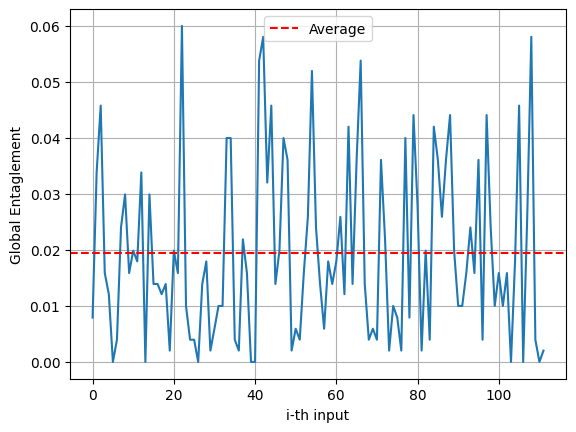

In [ ]:
xs = [x for x in range(len(train_global_ent_list))]

plt.plot(xs, train_global_ent_list)
plt.axhline(y=train_aver, color='red', linestyle='--', label='Average')
plt.xlabel("i-th input")
plt.ylabel("Global Entaglement")
plt.grid()
plt.legend()
#plt.savefig("aver_glob_ent.svg")
plt.show()

tensor([[4.8265, 5.7884, 3.3527],
        [3.6796, 3.8299, 4.5888]], dtype=torch.float64)


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

tensor([[4.8265, 5.4695, 3.7872],
        [3.6796, 4.1623, 3.2760]], dtype=torch.float64)


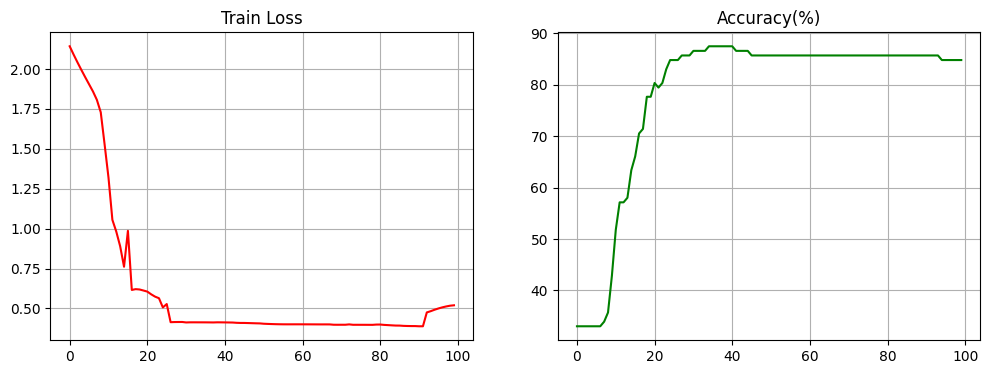

In [ ]:
epochs = 100
lr = 0.001 # learning rate
loss_opt = 'cross_entropy'

print(vqc.parameters)

loss_list, acc_list = vqc.train(train_loader, train_data, y_train, epochs, lr, loss_opt)

if (loss_list == None):
  print("Something went wrong with the training. Try again!")

print(vqc.parameters)

print_figs(loss_list, acc_list)

In [ ]:
y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

train_aver_glob_ent_list_1.append(round(train_aver, 3))
test_aver_glob_ent_list_1.append(round(test_aver, 3))
train_set_acc_list_1.append(round(accuracy_score(y_train, y_train_pred) * 100, 2))
test_set_acc_list_1.append(round(accuracy_score(y_test, y_test_pred) * 100, 2))

In [ ]:
ansatz = [[["Hadamard", 0], ["CNOT", 0, 1]], []]
#ansatz = [["Hadamard", 1], ["CNOT", 0, 1]]
#ansatz = [[["Hadamard", 0], ["CNOT", 0, 1]], [["Hadamard", 1], ["CNOT", 0, 1]]]
#ansatz = [[["CNOT", 0, 1]], [["CNOT", 1, 0]]]

vqc = VariationalQuantumClassifier(qubits, encoding, ansatz)
vqc.print()

y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

print("Train set accuracy: ", accuracy_score(y_train, y_train_pred) * 100, "%")
print("Train Global Entaglement average: ", train_aver)
print("Test set accuracy: ", accuracy_score(y_test, y_test_pred) * 100, "%")
print("Test Global Entaglement average: ", test_aver)


|0> --| A |--| H |--●--| RZ |--| RY |--| RZ |-
                    ¦                         
|0> --| A |---------+--| RZ |--| RY |--| RZ |-

Train set accuracy:  2.6785714285714284 %
Train Global Entaglement average:  0.044971642857142835
Test set accuracy:  0.0 %
Test Global Entaglement average:  0.040440973684210534


tensor([[4.8265, 5.7884, 3.3527],
        [3.6796, 3.8299, 4.5888]], dtype=torch.float64)


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

tensor([[4.8265, 6.4802, 3.2060],
        [3.6796, 3.8846, 3.0920]], dtype=torch.float64)


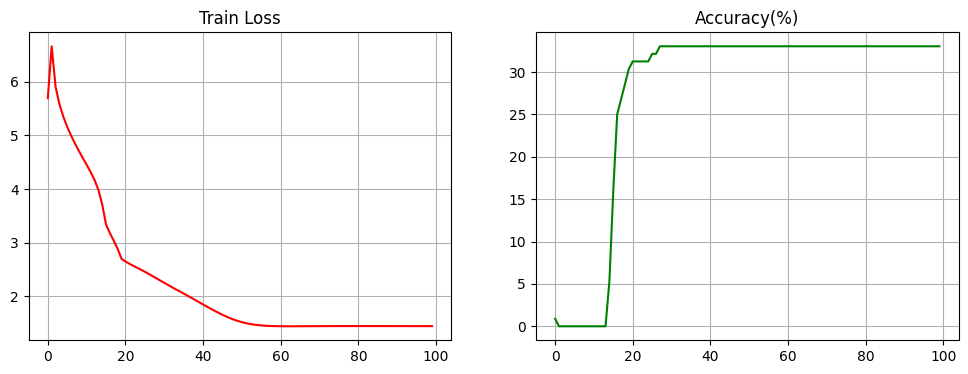

In [ ]:
epochs = 100
lr = 0.001 # learning rate
loss_opt = 'cross_entropy'

print(vqc.parameters)

loss_list, acc_list = vqc.train(train_loader, train_data, y_train, epochs, lr, loss_opt)

if (loss_list == None):
  print("Something went wrong with the training. Try again!")

print(vqc.parameters)

print_figs(loss_list, acc_list)

In [ ]:
y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

train_aver_glob_ent_list_1.append(round(train_aver, 3))
test_aver_glob_ent_list_1.append(round(test_aver, 3))
train_set_acc_list_1.append(round(accuracy_score(y_train, y_train_pred) * 100, 2))
test_set_acc_list_1.append(round(accuracy_score(y_test, y_test_pred) * 100, 2))

In [ ]:
ansatz = [[["Hadamard", 0], ["CNOT", 0, 1]], [["Hadamard", 1], ["CNOT", 0, 1]]]
#ansatz = [[["CNOT", 0, 1]], [["CNOT", 1, 0]]]

vqc = VariationalQuantumClassifier(qubits, encoding, ansatz)
vqc.print()

y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

print("Train set accuracy: ", accuracy_score(y_train, y_train_pred) * 100, "%")
print("Train Global Entaglement average: ", train_aver)
print("Test set accuracy: ", accuracy_score(y_test, y_test_pred) * 100, "%")
print("Test Global Entaglement average: ", test_aver)


|0> --| A |--| H |--●--| RZ |--| RY |--| RZ |---------●-
                    ¦                                 ¦ 
|0> --| A |---------+--| RZ |--| RY |--| RZ |--| H |--+-

Train set accuracy:  33.035714285714285 %
Train Global Entaglement average:  0.5175989017857142
Test set accuracy:  34.21052631578947 %
Test Global Entaglement average:  0.5257833947368423


tensor([[4.8265, 5.7884, 3.3527],
        [3.6796, 3.8299, 4.5888]], dtype=torch.float64)


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

tensor([[4.8265, 6.3208, 3.3517],
        [0.7520, 3.0739, 2.8671]], dtype=torch.float64)


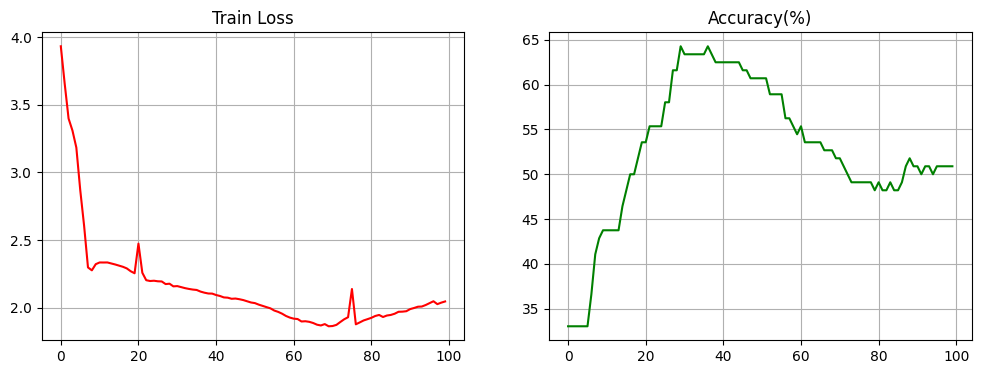

In [ ]:
epochs = 100
lr = 0.001 # learning rate
loss_opt = 'cross_entropy'

print(vqc.parameters)

loss_list, acc_list = vqc.train(train_loader, train_data, y_train, epochs, lr, loss_opt)

if (loss_list == None):
  print("Something went wrong with the training. Try again!")

print(vqc.parameters)

print_figs(loss_list, acc_list)

In [ ]:
y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

train_aver_glob_ent_list_1.append(round(train_aver, 3))
test_aver_glob_ent_list_1.append(round(test_aver, 3))
train_set_acc_list_1.append(round(accuracy_score(y_train, y_train_pred) * 100, 2))
test_set_acc_list_1.append(round(accuracy_score(y_test, y_test_pred) * 100, 2))

In [ ]:
ansatz = [[["CNOT", 0, 1]], [["CNOT", 1, 0]]]

vqc = VariationalQuantumClassifier(qubits, encoding, ansatz)
vqc.print()

y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

print("Train set accuracy: ", accuracy_score(y_train, y_train_pred) * 100, "%")
print("Train Global Entaglement average: ", train_aver)
print("Test set accuracy: ", accuracy_score(y_test, y_test_pred) * 100, "%")
print("Test Global Entaglement average: ", test_aver)


|0> --| A |--●--| RZ |--| RY |--| RZ |--+-
             ¦                          ¦ 
|0> --| A |--+--| RZ |--| RY |--| RZ |--●-

Train set accuracy:  33.035714285714285 %
Train Global Entaglement average:  0.6992070892857148
Test set accuracy:  34.21052631578947 %
Test Global Entaglement average:  0.7037382368421055


tensor([[4.8265, 5.7884, 3.3527],
        [3.6796, 3.8299, 4.5888]], dtype=torch.float64)


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

tensor([[4.8265, 6.0921, 3.4546],
        [3.6796, 3.4047, 3.3552]], dtype=torch.float64)


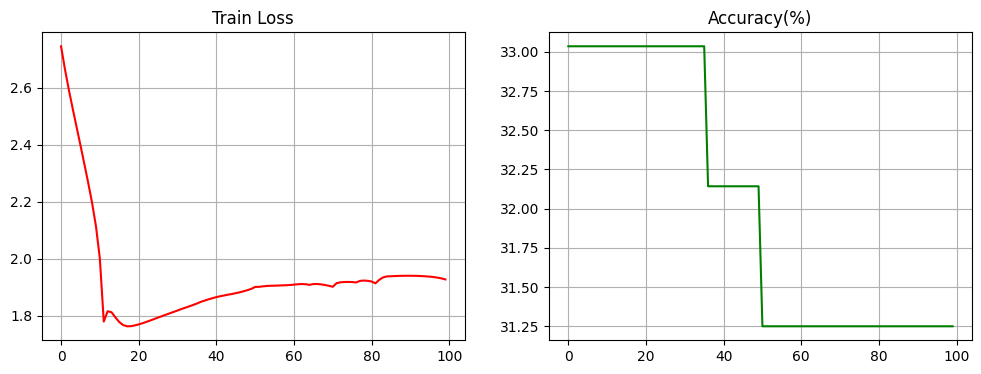

In [ ]:
epochs = 100
lr = 0.001 # learning rate
loss_opt = 'cross_entropy'

print(vqc.parameters)

loss_list, acc_list = vqc.train(train_loader, train_data, y_train, epochs, lr, loss_opt)

if (loss_list == None):
  print("Something went wrong with the training. Try again!")

print(vqc.parameters)

print_figs(loss_list, acc_list)

In [ ]:
y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

train_aver_glob_ent_list_1.append(round(train_aver, 3))
test_aver_glob_ent_list_1.append(round(test_aver, 3))
train_set_acc_list_1.append(round(accuracy_score(y_train, y_train_pred) * 100, 2))
test_set_acc_list_1.append(round(accuracy_score(y_test, y_test_pred) * 100, 2))

Circuits with rotation encoding

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)
X_train = minmax_scale(X_train, (0, 2 * math.pi), axis=0)
X_test = minmax_scale(X_test, (0, 2 * math.pi), axis=0)
train_data = torch.tensor(X_train, dtype = torch.complex128)
test_data = torch.tensor(X_test, dtype = torch.complex128)

print(X_train.shape)
print(y_train.shape)

n = X.shape[1] # n features = n qubits

(112, 4)
(112,)


In [ ]:
batch_size = 8
train_set = dataset(X_train, y_train)
test_set = dataset(X_test, y_test)
# DataLoader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [ ]:
qubits = n
encoding = ["rotation", "y", 1]
ansatz = []
#ansatz = [[["Hadamard", 0], ["CNOT", 0, 1]], []]
#ansatz = [[["Hadamard", 0], ["CNOT", 0, 1], ["CNOT", 1, 2]], []]
#ansatz = [[["Hadamard", 0], ["CNOT", 0, 1], ["CNOT", 1, 2], ["CNOT", 2, 3]], []]
#ansatz = [[["CNOT", 0, 1], ["CNOT", 1, 2], ["CNOT", 2, 3]], []]
seed = 24134345

vqc = VariationalQuantumClassifier(qubits, encoding, ansatz, seed=seed)
vqc.print()

y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

print("Train set accuracy: ", accuracy_score(y_train, y_train_pred) * 100, "%")
print("Train Global Entaglement average: ", train_aver)
print("Test set accuracy: ", accuracy_score(y_test, y_test_pred) * 100, "%")
print("Test Global Entaglement average: ", test_aver)


|0> --| RY |--| RZ |--| RY |--| RZ |-
             
|0> --| RY |--| RZ |--| RY |--| RZ |-
             
|0> --| RY |--| RZ |--| RY |--| RZ |-
             
|0> --| RY |--| RZ |--| RY |--| RZ |-

Train set accuracy:  33.035714285714285 %
Train Global Entaglement average:  0.0
Test set accuracy:  34.21052631578947 %
Test Global Entaglement average:  0.0


tensor([[6.0321, 3.7947, 3.0887],
        [6.0941, 4.3880, 6.2689],
        [2.0475, 3.2481, 0.7260],
        [1.0489, 5.4651, 0.4536]], dtype=torch.float64)


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

tensor([[ 6.3015,  4.8527,  3.0358],
        [ 6.1849,  5.6233,  6.3479],
        [ 1.9609,  3.7352, -0.4724],
        [ 1.7751,  6.2331,  1.1798]], dtype=torch.float64)


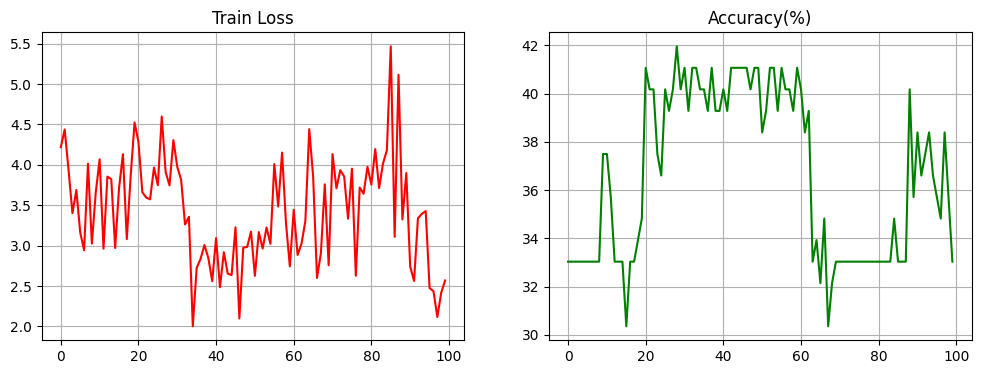

In [ ]:
epochs = 100
lr = 0.01 # learning rate
loss_opt = 'cross_entropy'

print(vqc.parameters)

loss_list, acc_list = vqc.train(train_loader, train_data, y_train, epochs, lr, loss_opt)

if (loss_list == None):
  print("Something went wrong with the training. Try again!")

print(vqc.parameters)

print_figs(loss_list, acc_list)

In [ ]:
y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

train_aver_glob_ent_list_1.append(round(train_aver, 3))
test_aver_glob_ent_list_1.append(round(test_aver, 3))
train_set_acc_list_1.append(round(accuracy_score(y_train, y_train_pred) * 100, 2))
test_set_acc_list_1.append(round(accuracy_score(y_test, y_test_pred) * 100, 2))

In [ ]:
ansatz = [[["CNOT", 0, 1]], []]

vqc = VariationalQuantumClassifier(qubits, encoding, ansatz, seed=seed)
vqc.print()

y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

print("Train set accuracy: ", accuracy_score(y_train, y_train_pred) * 100, "%")
print("Train Global Entaglement average: ", train_aver)
print("Test set accuracy: ", accuracy_score(y_test, y_test_pred) * 100, "%")
print("Test Global Entaglement average: ", test_aver)


|0> --| RY |--●--| RZ |--| RY |--| RZ |-
              ¦                         
|0> --| RY |--+--| RZ |--| RY |--| RZ |-
                                        
|0> --| RY |-----| RZ |--| RY |--| RZ |-
                                        
|0> --| RY |-----| RZ |--| RY |--| RZ |-

Train set accuracy:  33.92857142857143 %
Train Global Entaglement average:  0.05924394642857144
Test set accuracy:  28.947368421052634 %
Test Global Entaglement average:  0.05314263157894737


tensor([[6.0321, 3.7947, 3.0887],
        [6.0941, 4.3880, 6.2689],
        [2.0475, 3.2481, 0.7260],
        [1.0489, 5.4651, 0.4536]], dtype=torch.float64)


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

tensor([[6.3152, 3.7255, 2.9559],
        [6.2728, 4.6504, 6.2105],
        [0.8989, 3.1602, 0.7747],
        [1.0400, 6.2332, 0.4447]], dtype=torch.float64)


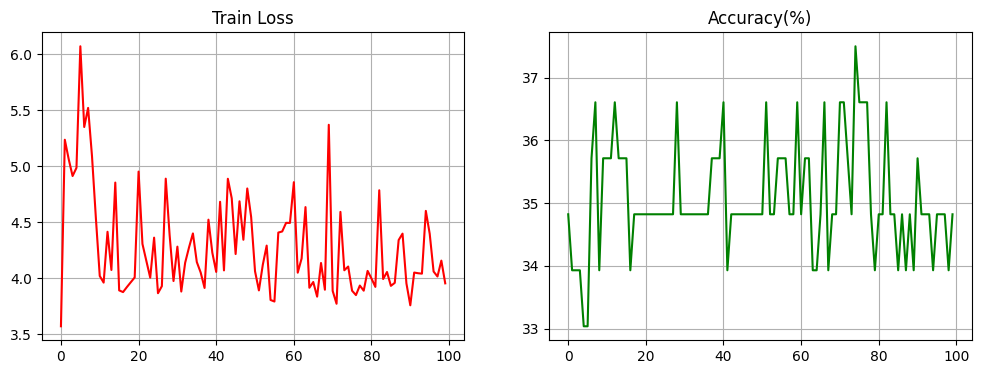

In [ ]:
epochs = 100
lr = 0.01 # learning rate
loss_opt = 'cross_entropy'

print(vqc.parameters)

loss_list, acc_list = vqc.train(train_loader, train_data, y_train, epochs, lr, loss_opt)

if (loss_list == None):
  print("Something went wrong with the training. Try again!")

print(vqc.parameters)

print_figs(loss_list, acc_list)

In [ ]:
y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

train_aver_glob_ent_list_1.append(round(train_aver, 3))
test_aver_glob_ent_list_1.append(round(test_aver, 3))
train_set_acc_list_1.append(round(accuracy_score(y_train, y_train_pred) * 100, 2))
test_set_acc_list_1.append(round(accuracy_score(y_test, y_test_pred) * 100, 2))

In [ ]:
ansatz = [[["CNOT", 0, 1], ["CNOT", 1, 2]], []]

vqc = VariationalQuantumClassifier(qubits, encoding, ansatz, seed=seed)
vqc.print()

y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

print("Train set accuracy: ", accuracy_score(y_train, y_train_pred) * 100, "%")
print("Train Global Entaglement average: ", train_aver)
print("Test set accuracy: ", accuracy_score(y_test, y_test_pred) * 100, "%")
print("Test Global Entaglement average: ", test_aver)


|0> --| RY |--●-----| RZ |--| RY |--| RZ |-
              ¦                            
|0> --| RY |--+--●--| RZ |--| RY |--| RZ |-
                 ¦                         
|0> --| RY |-----+--| RZ |--| RY |--| RZ |-
                                           
|0> --| RY |--------| RZ |--| RY |--| RZ |-

Train set accuracy:  33.035714285714285 %
Train Global Entaglement average:  0.13286996875000004
Test set accuracy:  34.21052631578947 %
Test Global Entaglement average:  0.11942045394736842


tensor([[6.0321, 3.7947, 3.0887],
        [6.0941, 4.3880, 6.2689],
        [2.0475, 3.2481, 0.7260],
        [1.0489, 5.4651, 0.4536]], dtype=torch.float64)


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

tensor([[5.6845, 2.8317, 2.7038],
        [4.8378, 2.7567, 4.8378],
        [0.1710, 3.6221, 0.0794],
        [1.1417, 6.2332, 0.5464]], dtype=torch.float64)


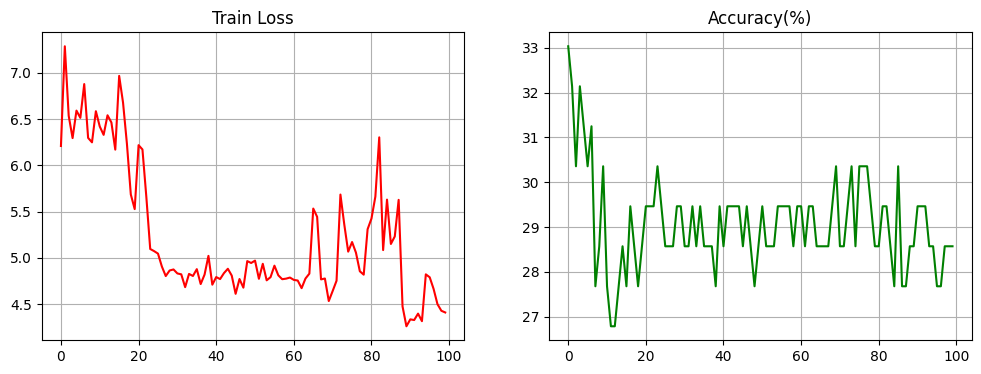

In [ ]:
epochs = 100
lr = 0.01 # learning rate
loss_opt = 'cross_entropy'

print(vqc.parameters)

loss_list, acc_list = vqc.train(train_loader, train_data, y_train, epochs, lr, loss_opt)

if (loss_list == None):
  print("Something went wrong with the training. Try again!")

print(vqc.parameters)

print_figs(loss_list, acc_list)

In [ ]:
y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

train_aver_glob_ent_list_1.append(round(train_aver, 3))
test_aver_glob_ent_list_1.append(round(test_aver, 3))
train_set_acc_list_1.append(round(accuracy_score(y_train, y_train_pred) * 100, 2))
test_set_acc_list_1.append(round(accuracy_score(y_test, y_test_pred) * 100, 2))

In [ ]:
ansatz = [[["CNOT", 0, 1], ["CNOT", 1, 2], ["CNOT", 2, 3]], [["CNOT", 2, 3], ["CNOT", 1, 2], ["CNOT", 0, 1]]]

vqc = VariationalQuantumClassifier(qubits, encoding, ansatz, seed=seed)
vqc.print()

y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

print("Train set accuracy: ", accuracy_score(y_train, y_train_pred) * 100, "%")
print("Train Global Entaglement average: ", train_aver)
print("Test set accuracy: ", accuracy_score(y_test, y_test_pred) * 100, "%")
print("Test Global Entaglement average: ", test_aver)


|0> --| RY |--●--------| RZ |--| RY |--| RZ |--------●-
              ¦                                      ¦ 
|0> --| RY |--+--●-----| RZ |--| RY |--| RZ |-----●--+-
                 ¦                                ¦    
|0> --| RY |-----+--●--| RZ |--| RY |--| RZ |--●--+----
                    ¦                          ¦       
|0> --| RY |--------+--| RZ |--| RY |--| RZ |--+-------

Train set accuracy:  33.035714285714285 %
Train Global Entaglement average:  0.4399355022321428
Test set accuracy:  34.21052631578947 %
Test Global Entaglement average:  0.43958369736842107


tensor([[6.0321, 3.7947, 3.0887],
        [6.0941, 4.3880, 6.2689],
        [2.0475, 3.2481, 0.7260],
        [1.0489, 5.4651, 0.4536]], dtype=torch.float64)


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

tensor([[ 6.1874,  3.8646,  3.0587],
        [ 5.5833,  3.1683,  5.5957],
        [-0.6657,  3.0935, -2.2292],
        [ 0.8003,  6.2557,  0.7181]], dtype=torch.float64)


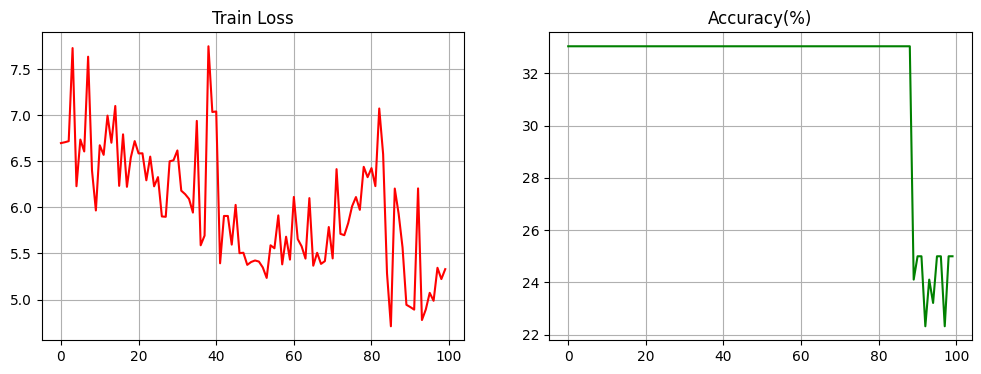

In [ ]:
epochs = 100
lr = 0.01 # learning rate
loss_opt = 'cross_entropy'

print(vqc.parameters)

loss_list, acc_list = vqc.train(train_loader, train_data, y_train, epochs, lr, loss_opt)

if (loss_list == None):
  print("Something went wrong with the training. Try again!")

print(vqc.parameters)

print_figs(loss_list, acc_list)

In [ ]:
y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

train_aver_glob_ent_list_1.append(round(train_aver, 3))
test_aver_glob_ent_list_1.append(round(test_aver, 3))
train_set_acc_list_1.append(round(accuracy_score(y_train, y_train_pred) * 100, 2))
test_set_acc_list_1.append(round(accuracy_score(y_test, y_test_pred) * 100, 2))

In [ ]:
ansatz = [[["CNOT", 0, 1], ["CNOT", 1, 2], ["CNOT", 2, 3]], []]

vqc = VariationalQuantumClassifier(qubits, encoding, ansatz, seed=seed)
vqc.print()

y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

print("Train set accuracy: ", accuracy_score(y_train, y_train_pred) * 100, "%")
print("Train Global Entaglement average: ", train_aver)
print("Test set accuracy: ", accuracy_score(y_test, y_test_pred) * 100, "%")
print("Test Global Entaglement average: ", test_aver)


|0> --| RY |--●--------| RZ |--| RY |--| RZ |-
              ¦                               
|0> --| RY |--+--●-----| RZ |--| RY |--| RZ |-
                 ¦                            
|0> --| RY |-----+--●--| RZ |--| RY |--| RZ |-
                    ¦                         
|0> --| RY |--------+--| RZ |--| RY |--| RZ |-

Train set accuracy:  33.035714285714285 %
Train Global Entaglement average:  0.4324850580357143
Test set accuracy:  34.21052631578947 %
Test Global Entaglement average:  0.4189968815789474


tensor([[6.0321, 3.7947, 3.0887],
        [6.0941, 4.3880, 6.2689],
        [2.0475, 3.2481, 0.7260],
        [1.0489, 5.4651, 0.4536]], dtype=torch.float64)


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

tensor([[ 3.7138,  2.8455,  0.7837],
        [ 4.4068,  3.1276,  4.3913],
        [-0.4555,  3.8214, -0.7691],
        [-0.0560,  4.8714,  0.0276]], dtype=torch.float64)


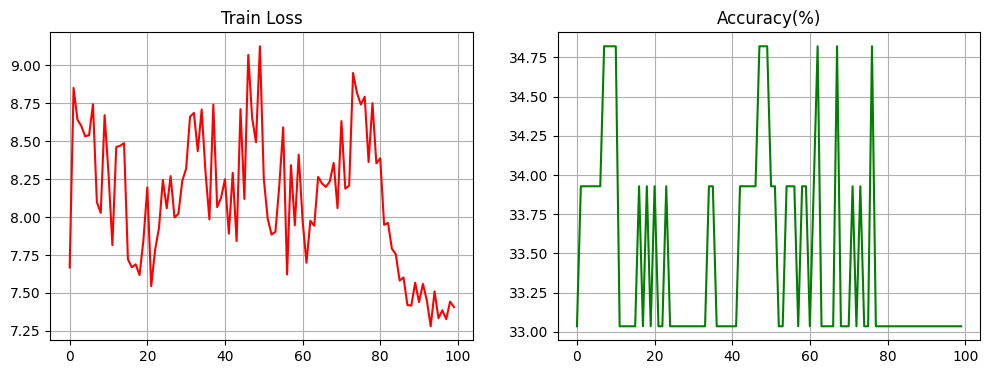

In [ ]:
epochs = 100
lr = 0.01 # learning rate
loss_opt = 'cross_entropy'

print(vqc.parameters)

loss_list, acc_list = vqc.train(train_loader, train_data, y_train, epochs, lr, loss_opt)

if (loss_list == None):
  print("Something went wrong with the training. Try again!")

print(vqc.parameters)

print_figs(loss_list, acc_list)

In [ ]:
y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

train_aver_glob_ent_list_1.append(round(train_aver, 3))
test_aver_glob_ent_list_1.append(round(test_aver, 3))
train_set_acc_list_1.append(round(accuracy_score(y_train, y_train_pred) * 100, 2))
test_set_acc_list_1.append(round(accuracy_score(y_test, y_test_pred) * 100, 2))

In [ ]:
ansatz = [[], [["CNOT", 0, 1], ["CNOT", 1, 2], ["CNOT", 2, 3]]]

vqc = VariationalQuantumClassifier(qubits, encoding, ansatz, seed=seed)
vqc.print()

y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

print("Train set accuracy: ", accuracy_score(y_train, y_train_pred) * 100, "%")
print("Train Global Entaglement average: ", train_aver)
print("Test set accuracy: ", accuracy_score(y_test, y_test_pred) * 100, "%")
print("Test Global Entaglement average: ", test_aver)


|0> --| RY |--| RZ |--| RY |--| RZ |--●-------
                                      ¦       
|0> --| RY |--| RZ |--| RY |--| RZ |--+--●----
                                         ¦    
|0> --| RY |--| RZ |--| RY |--| RZ |-----+--●-
                                            ¦ 
|0> --| RY |--| RZ |--| RY |--| RZ |--------+-

Train set accuracy:  33.035714285714285 %
Train Global Entaglement average:  0.7439648906249998
Test set accuracy:  34.21052631578947 %
Test Global Entaglement average:  0.7408165789473684


tensor([[6.0321, 3.7947, 3.0887],
        [6.0941, 4.3880, 6.2689],
        [2.0475, 3.2481, 0.7260],
        [1.0489, 5.4651, 0.4536]], dtype=torch.float64)


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

tensor([[ 6.3164e+00,  4.5279e+00,  3.1198e+00],
        [ 6.4060e+00,  4.2010e+00,  6.2566e+00],
        [ 2.2210e+00,  2.9173e+00, -8.5056e-01],
        [-1.7909e-01,  5.7305e+00, -2.6185e-03]], dtype=torch.float64)


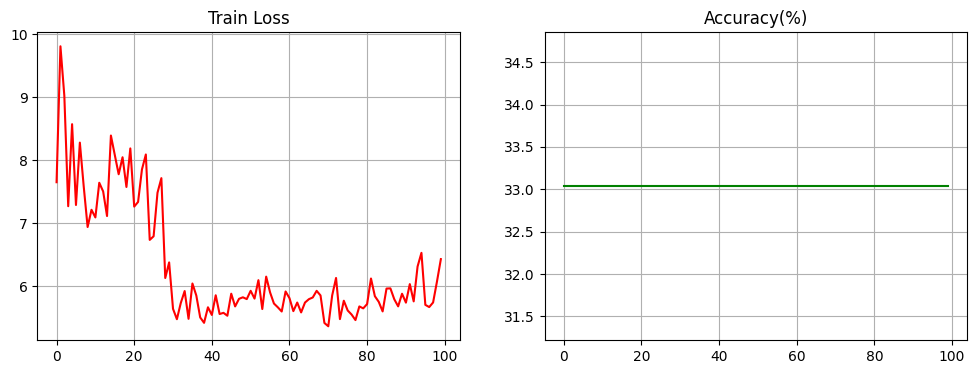

In [ ]:
epochs = 100
lr = 0.01 # learning rate
loss_opt = 'cross_entropy'

print(vqc.parameters)

loss_list, acc_list = vqc.train(train_loader, train_data, y_train, epochs, lr, loss_opt)

if (loss_list == None):
  print("Something went wrong with the training. Try again!")

print(vqc.parameters)

print_figs(loss_list, acc_list)

In [ ]:
y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

train_aver_glob_ent_list_1.append(round(train_aver, 3))
test_aver_glob_ent_list_1.append(round(test_aver, 3))
train_set_acc_list_1.append(round(accuracy_score(y_train, y_train_pred) * 100, 2))
test_set_acc_list_1.append(round(accuracy_score(y_test, y_test_pred) * 100, 2))

Correlation between Average Global Entaglement and Accuracy for IRIS dataset

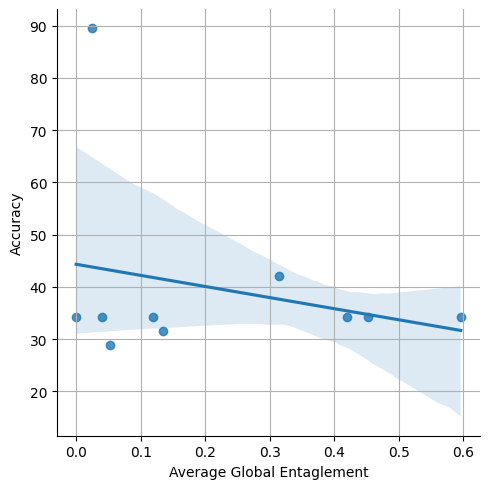

In [ ]:
my_array = np.array([test_aver_glob_ent_list_1, test_set_acc_list_1])

df = pd.DataFrame(np.transpose(my_array), columns=['Average Global Entaglement', 'Accuracy'])

# sns.scatterplot(x="Average Global Entaglement", y="Accuracy", data = df);
sns.lmplot(x="Average Global Entaglement", y="Accuracy", data = df);
plt.grid()
# plt.savefig("age_acc_1.svg")
plt.show()

Concentric Circles dataset

In [ ]:
X, y = make_circles(n_samples=500, factor=0.3, noise=0.05, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

train_data = torch.tensor(X_train, dtype = torch.complex128)
test_data = torch.tensor(X_test, dtype = torch.complex128)

print(X_train.shape)
print(y_train.shape)
print(X_train[0])
print(y_train[0])
n = X.shape[1] # n features = n qubits

(375, 2)
(375,)
[0.87382449 0.61860822]
0


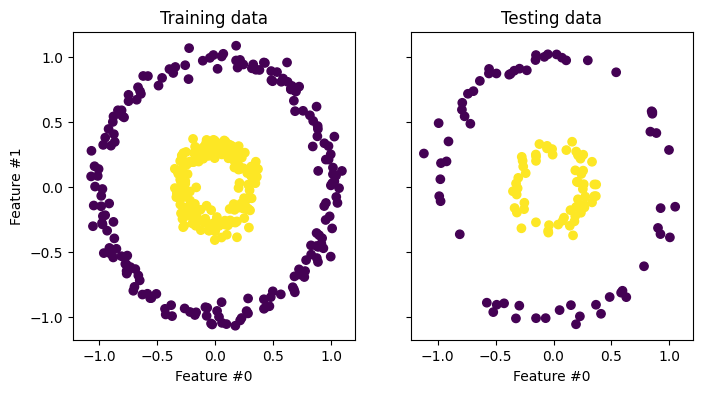

In [ ]:
_, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))

train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
train_ax.set_ylabel("Feature #1")
train_ax.set_xlabel("Feature #0")
train_ax.set_title("Training data")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
test_ax.set_xlabel("Feature #0")
_ = test_ax.set_title("Testing data")

In [ ]:
batch_size = 15
train_set = dataset(X_train, y_train)
test_set = dataset(X_test, y_test)
# DataLoader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [ ]:
train_aver_glob_ent_list_2 = [] # list with all the Concetric Circles train set Average Global Entaglement measures
test_aver_glob_ent_list_2 = [] # list with all the Concetric Circles test set Average Global Entaglement measures
train_set_acc_list_2 = [] # list with all the Concetric Circles train set Accuracy measures
test_set_acc_list_2 = [] # list with all the Concetric Circles test set Accuracy measures

Amplitude Encoding

In [ ]:
qubits = int(math.log(n, 2))
print("Qubits:", qubits)
encoding = ["amplitude", "x", 1]
ansatz = []
cls = 2
#ansatz = [[["Hadamard", 0]], []]
#ansatz = [[["Hadamard", 0]], [["Hadamard", 0]]]
seed = 0

vqc = VariationalQuantumClassifier(qubits, encoding, ansatz, seed)
vqc.print()

y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

print("Train set accuracy: ", accuracy_score(y_train, y_train_pred) * 100, "%")
print("Train Global Entaglement average: ", train_aver)
print("Test set accuracy: ", accuracy_score(y_test, y_test_pred) * 100, "%")
print("Test Global Entaglement average: ", test_aver)

Qubits: 1

|0> --| A |--| RZ |--| RY |--| RZ |-

Train set accuracy:  50.13333333333333 %
Train Global Entaglement average:  0.0
Test set accuracy:  52.0 %
Test Global Entaglement average:  0.0


tensor([[0.1882, 1.8358, 3.3968]], dtype=torch.float64)


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

tensor([[0.1882, 1.5257, 4.6247]], dtype=torch.float64)


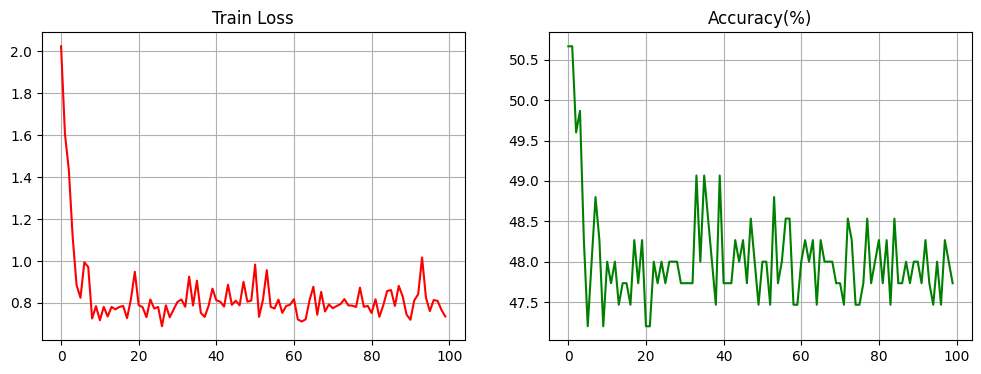

In [ ]:
epochs = 100
lr = 0.01 # learning rate
loss_opt = 'cross_entropy'

print(vqc.parameters)

loss_list, acc_list = vqc.train(train_loader, train_data, y_train, epochs, lr, loss_opt)

if (loss_list == None):
  print("Something went wrong with the training. Try again!")

print(vqc.parameters)

print_figs(loss_list, acc_list)

In [ ]:
y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

train_aver_glob_ent_list_2.append(round(train_aver, 3))
test_aver_glob_ent_list_2.append(round(test_aver, 3))
train_set_acc_list_2.append(round(accuracy_score(y_train, y_train_pred) * 100, 2))
test_set_acc_list_2.append(round(accuracy_score(y_test, y_test_pred) * 100, 2))

In [ ]:
ansatz = [[["Hadamard", 0]], []]

vqc = VariationalQuantumClassifier(qubits, encoding, ansatz, seed)
vqc.print()

y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

print("Train set accuracy: ", accuracy_score(y_train, y_train_pred) * 100, "%")
print("Train Global Entaglement average: ", train_aver)
print("Test set accuracy: ", accuracy_score(y_test, y_test_pred) * 100, "%")
print("Test Global Entaglement average: ", test_aver)


|0> --| A |--| H |--| RZ |--| RY |--| RZ |-

Train set accuracy:  47.733333333333334 %
Train Global Entaglement average:  0.0
Test set accuracy:  56.8 %
Test Global Entaglement average:  0.0


tensor([[0.1882, 1.8358, 3.3968]], dtype=torch.float64)


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

tensor([[0.1882, 1.4802, 4.6742]], dtype=torch.float64)


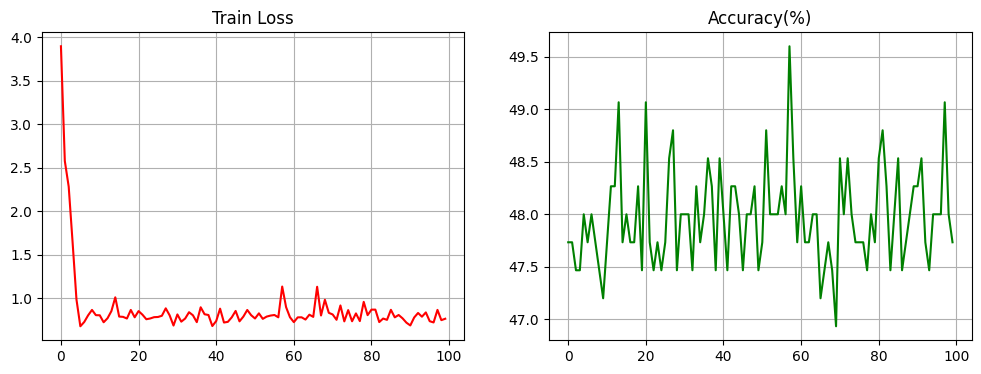

In [ ]:
epochs = 100
lr = 0.01 # learning rate
loss_opt = 'cross_entropy'

print(vqc.parameters)

loss_list, acc_list = vqc.train(train_loader, train_data, y_train, epochs, lr, loss_opt)

if (loss_list == None):
  print("Something went wrong with the training. Try again!")

print(vqc.parameters)

print_figs(loss_list, acc_list)

In [ ]:
y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

train_aver_glob_ent_list_2.append(round(train_aver, 3))
test_aver_glob_ent_list_2.append(round(test_aver, 3))
train_set_acc_list_2.append(round(accuracy_score(y_train, y_train_pred) * 100, 2))
test_set_acc_list_2.append(round(accuracy_score(y_test, y_test_pred) * 100, 2))

In [ ]:
ansatz = [[["Hadamard", 0]], [["Hadamard", 0]]]

vqc = VariationalQuantumClassifier(qubits, encoding, ansatz, seed)
vqc.print()

y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

print("Train set accuracy: ", accuracy_score(y_train, y_train_pred) * 100, "%")
print("Train Global Entaglement average: ", train_aver)
print("Test set accuracy: ", accuracy_score(y_test, y_test_pred) * 100, "%")
print("Test Global Entaglement average: ", test_aver)


|0> --| A |--| H |--| RZ |--| RY |--| RZ |--| H |-

Train set accuracy:  48.0 %
Train Global Entaglement average:  0.0
Test set accuracy:  56.8 %
Test Global Entaglement average:  0.0


tensor([[0.1882, 1.8358, 3.3968]], dtype=torch.float64)


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

tensor([[-31.1955,   3.0484, -29.6677]], dtype=torch.float64)


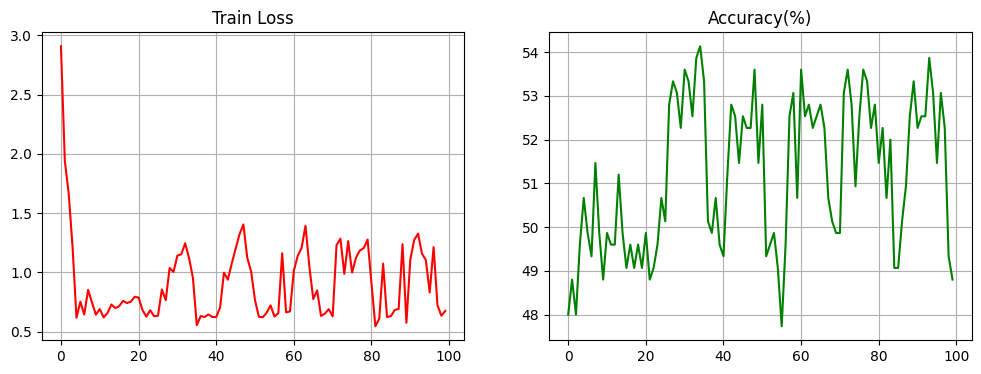

In [ ]:
epochs = 100
lr = 0.01 # learning rate
loss_opt = 'cross_entropy'

print(vqc.parameters)

loss_list, acc_list = vqc.train(train_loader, train_data, y_train, epochs, lr, loss_opt)

if (loss_list == None):
  print("Something went wrong with the training. Try again!")

print(vqc.parameters)

print_figs(loss_list, acc_list)

In [ ]:
y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

train_aver_glob_ent_list_2.append(round(train_aver, 3))
test_aver_glob_ent_list_2.append(round(test_aver, 3))
train_set_acc_list_2.append(round(accuracy_score(y_train, y_train_pred) * 100, 2))
test_set_acc_list_2.append(round(accuracy_score(y_test, y_test_pred) * 100, 2))

Rotation Encoding

In [ ]:
qubits = n
print("Qubits:", qubits)
encoding = ["rotation", "y", 1]
ansatz = []
cls = 2
#ansatz = [[["Hadamard", 0], ["CNOT", 0, 1]], []]
#ansatz = [[["Hadamard", 1], ["CNOT", 0, 1]], []]
#ansatz = [[["Hadamard", 0], ["CNOT", 0, 1]], [["Hadamard", 1], ["CNOT", 0, 1]]]
#ansatz = [[["CNOT", 0, 1]], [["CNOT", 1, 0]]]

vqc = VariationalQuantumClassifier(qubits, encoding, ansatz, seed)
vqc.print()

y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

print("Train set accuracy: ", accuracy_score(y_train, y_train_pred) * 100, "%")
print("Train Global Entaglement average: ", train_aver)
print("Test set accuracy: ", accuracy_score(y_test, y_test_pred) * 100, "%")
print("Test Global Entaglement average: ", test_aver)

Qubits: 2

|0> --| RY |--| RZ |--| RY |--| RZ |-
             
|0> --| RY |--| RZ |--| RY |--| RZ |-

Train set accuracy:  59.199999999999996 %
Train Global Entaglement average:  0.0
Test set accuracy:  58.4 %
Test Global Entaglement average:  0.0


tensor([[0.1882, 1.8358, 3.3968],
        [0.4980, 2.2304, 1.3123]], dtype=torch.float64)


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

tensor([[0.6524, 1.5993, 3.9429],
        [0.6605, 1.6144, 1.4748]], dtype=torch.float64)


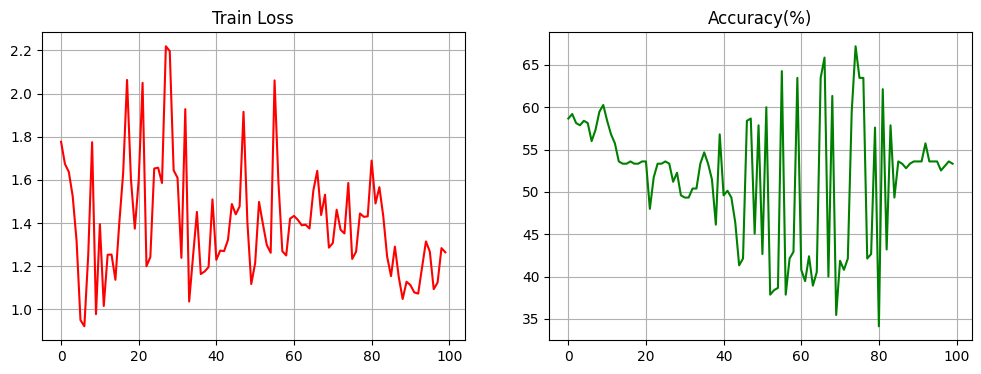

In [ ]:
epochs = 100
lr = 0.01 # learning rate
loss_opt = 'cross_entropy'

print(vqc.parameters)

loss_list, acc_list = vqc.train(train_loader, train_data, y_train, epochs, lr, loss_opt)

if (loss_list == None):
  print("Something went wrong with the training. Try again!")

print(vqc.parameters)

print_figs(loss_list, acc_list)

In [ ]:
y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

train_aver_glob_ent_list_2.append(round(train_aver, 3))
test_aver_glob_ent_list_2.append(round(test_aver, 3))
train_set_acc_list_2.append(round(accuracy_score(y_train, y_train_pred) * 100, 2))
test_set_acc_list_2.append(round(accuracy_score(y_test, y_test_pred) * 100, 2))

In [ ]:
ansatz = [[["Hadamard", 0], ["CNOT", 0, 1]], []]

vqc = VariationalQuantumClassifier(qubits, encoding, ansatz, seed)
vqc.print()

y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

print("Train set accuracy: ", accuracy_score(y_train, y_train_pred) * 100, "%")
print("Train Global Entaglement average: ", train_aver)
print("Test set accuracy: ", accuracy_score(y_test, y_test_pred) * 100, "%")
print("Test Global Entaglement average: ", test_aver)


|0> --| RY |--| H |--●--| RZ |--| RY |--| RZ |-
                     ¦                         
|0> --| RY |---------+--| RZ |--| RY |--| RZ |-

Train set accuracy:  50.13333333333333 %
Train Global Entaglement average:  0.6411268266666666
Test set accuracy:  49.6 %
Test Global Entaglement average:  0.7021307839999996


tensor([[0.1882, 1.8358, 3.3968],
        [0.4980, 2.2304, 1.3123]], dtype=torch.float64)


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

tensor([[ 0.3577,  0.0427,  2.9138],
        [-2.0960,  1.7430, -0.2845]], dtype=torch.float64)


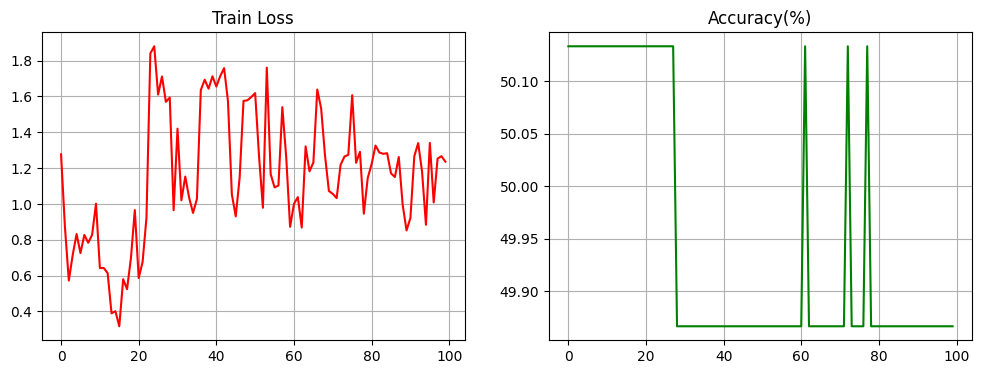

In [ ]:
epochs = 100
lr = 0.01 # learning rate
loss_opt = 'cross_entropy'

print(vqc.parameters)

loss_list, acc_list = vqc.train(train_loader, train_data, y_train, epochs, lr, loss_opt)

if (loss_list == None):
  print("Something went wrong with the training. Try again!")

print(vqc.parameters)

print_figs(loss_list, acc_list)

In [ ]:
y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

train_aver_glob_ent_list_2.append(round(train_aver, 3))
test_aver_glob_ent_list_2.append(round(test_aver, 3))
train_set_acc_list_2.append(round(accuracy_score(y_train, y_train_pred) * 100, 2))
test_set_acc_list_2.append(round(accuracy_score(y_test, y_test_pred) * 100, 2))

In [ ]:
ansatz = [[["Hadamard", 1], ["CNOT", 0, 1]], []]

vqc = VariationalQuantumClassifier(qubits, encoding, ansatz, seed)
vqc.print()

y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

print("Train set accuracy: ", accuracy_score(y_train, y_train_pred) * 100, "%")
print("Train Global Entaglement average: ", train_aver)
print("Test set accuracy: ", accuracy_score(y_test, y_test_pred) * 100, "%")
print("Test Global Entaglement average: ", test_aver)


|0> --| RY |---------●--| RZ |--| RY |--| RZ |-
                     ¦                         
|0> --| RY |--| H |--+--| RZ |--| RY |--| RZ |-

Train set accuracy:  59.199999999999996 %
Train Global Entaglement average:  0.0
Test set accuracy:  58.4 %
Test Global Entaglement average:  0.0


tensor([[0.1882, 1.8358, 3.3968],
        [0.4980, 2.2304, 1.3123]], dtype=torch.float64)


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

tensor([[-0.8360,  2.3012,  3.7303],
        [-0.2642,  2.3404,  1.2738]], dtype=torch.float64)


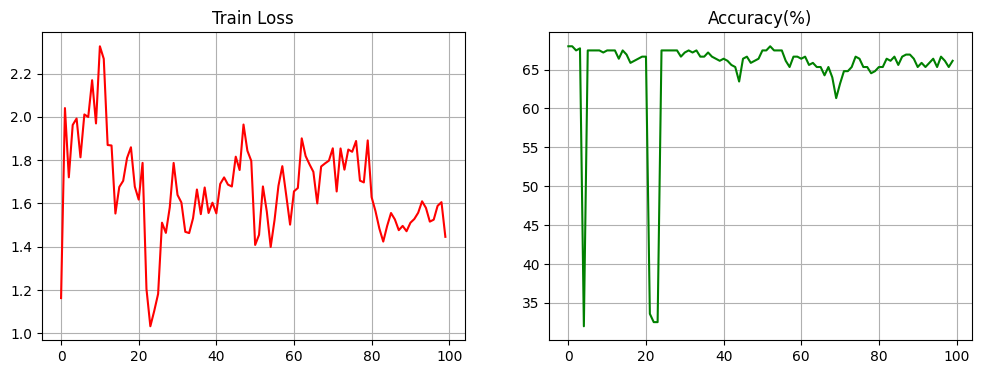

In [ ]:
epochs = 100
lr = 0.01 # learning rate
loss_opt = 'cross_entropy'

print(vqc.parameters)

loss_list, acc_list = vqc.train(train_loader, train_data, y_train, epochs, lr, loss_opt)

if (loss_list == None):
  print("Something went wrong with the training. Try again!")

print(vqc.parameters)

print_figs(loss_list, acc_list)

In [ ]:
y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

train_aver_glob_ent_list_2.append(round(train_aver, 3))
test_aver_glob_ent_list_2.append(round(test_aver, 3))
train_set_acc_list_2.append(round(accuracy_score(y_train, y_train_pred) * 100, 2))
test_set_acc_list_2.append(round(accuracy_score(y_test, y_test_pred) * 100, 2))

In [ ]:
ansatz = [[["Hadamard", 0], ["CNOT", 0, 1]], [["Hadamard", 1], ["CNOT", 0, 1]]]

vqc = VariationalQuantumClassifier(qubits, encoding, ansatz, seed)
vqc.print()

y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

print("Train set accuracy: ", accuracy_score(y_train, y_train_pred) * 100, "%")
print("Train Global Entaglement average: ", train_aver)
print("Test set accuracy: ", accuracy_score(y_test, y_test_pred) * 100, "%")
print("Test Global Entaglement average: ", test_aver)


|0> --| RY |--| H |--●--| RZ |--| RY |--| RZ |---------●-
                     ¦                                 ¦ 
|0> --| RY |---------+--| RZ |--| RY |--| RZ |--| H |--+-

Train set accuracy:  48.0 %
Train Global Entaglement average:  0.2247314399999999
Test set accuracy:  54.400000000000006 %
Test Global Entaglement average:  0.190650936


tensor([[0.1882, 1.8358, 3.3968],
        [0.4980, 2.2304, 1.3123]], dtype=torch.float64)


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

tensor([[0.7086, 1.0863, 3.1189],
        [0.1034, 1.8002, 2.0146]], dtype=torch.float64)


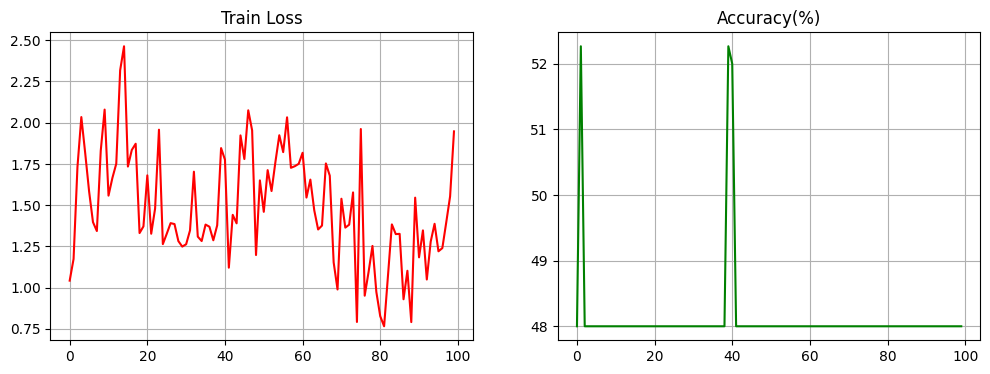

In [ ]:
epochs = 100
lr = 0.01 # learning rate
loss_opt = 'cross_entropy'

print(vqc.parameters)

loss_list, acc_list = vqc.train(train_loader, train_data, y_train, epochs, lr, loss_opt)

if (loss_list == None):
  print("Something went wrong with the training. Try again!")

print(vqc.parameters)

print_figs(loss_list, acc_list)

In [ ]:
y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

train_aver_glob_ent_list_2.append(round(train_aver, 3))
test_aver_glob_ent_list_2.append(round(test_aver, 3))
train_set_acc_list_2.append(round(accuracy_score(y_train, y_train_pred) * 100, 2))
test_set_acc_list_2.append(round(accuracy_score(y_test, y_test_pred) * 100, 2))

In [ ]:
ansatz = [[["CNOT", 0, 1]], [["CNOT", 1, 0]]]

vqc = VariationalQuantumClassifier(qubits, encoding, ansatz, seed)
vqc.print()

y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

print("Train set accuracy: ", accuracy_score(y_train, y_train_pred) * 100, "%")
print("Train Global Entaglement average: ", train_aver)
print("Test set accuracy: ", accuracy_score(y_test, y_test_pred) * 100, "%")
print("Test Global Entaglement average: ", test_aver)


|0> --| RY |--●--| RZ |--| RY |--| RZ |--+-
              ¦                          ¦ 
|0> --| RY |--+--| RZ |--| RY |--| RZ |--●-

Train set accuracy:  49.6 %
Train Global Entaglement average:  0.16738329066666652
Test set accuracy:  50.4 %
Test Global Entaglement average:  0.15606863999999998


tensor([[0.1882, 1.8358, 3.3968],
        [0.4980, 2.2304, 1.3123]], dtype=torch.float64)


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

tensor([[-0.5586,  1.8011,  4.0959],
        [ 1.4340,  1.6805,  1.5672]], dtype=torch.float64)


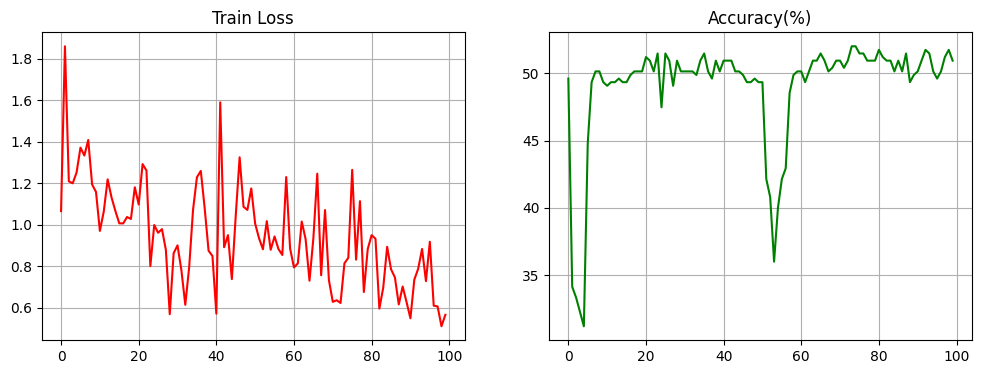

In [ ]:
epochs = 100
lr = 0.01 # learning rate
loss_opt = 'cross_entropy'

print(vqc.parameters)

loss_list, acc_list = vqc.train(train_loader, train_data, y_train, epochs, lr, loss_opt)

if (loss_list == None):
  print("Something went wrong with the training. Try again!")

print(vqc.parameters)

print_figs(loss_list, acc_list)

In [ ]:
y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

train_aver_glob_ent_list_2.append(round(train_aver, 3))
test_aver_glob_ent_list_2.append(round(test_aver, 3))
train_set_acc_list_2.append(round(accuracy_score(y_train, y_train_pred) * 100, 2))
test_set_acc_list_2.append(round(accuracy_score(y_test, y_test_pred) * 100, 2))

In [ ]:
ansatz = [[["Hadamard", 0], ["CNOT", 0, 1]], [["Hadamard", 1], ["CNOT", 1, 0]]]

vqc = VariationalQuantumClassifier(qubits, encoding, ansatz, seed)
vqc.print()

y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

print("Train set accuracy: ", accuracy_score(y_train, y_train_pred) * 100, "%")
print("Train Global Entaglement average: ", train_aver)
print("Test set accuracy: ", accuracy_score(y_test, y_test_pred) * 100, "%")
print("Test Global Entaglement average: ", test_aver)


|0> --| RY |--| H |--●--| RZ |--| RY |--| RZ |---------+-
                     ¦                                 ¦ 
|0> --| RY |---------+--| RZ |--| RY |--| RZ |--| H |--●-

Train set accuracy:  52.0 %
Train Global Entaglement average:  0.11036908799999988
Test set accuracy:  45.6 %
Test Global Entaglement average:  0.12009075999999999


tensor([[0.1882, 1.8358, 3.3968],
        [0.4980, 2.2304, 1.3123]], dtype=torch.float64)


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

tensor([[-0.0841,  0.7137,  2.8392],
        [-1.9881,  1.6090,  1.2189]], dtype=torch.float64)


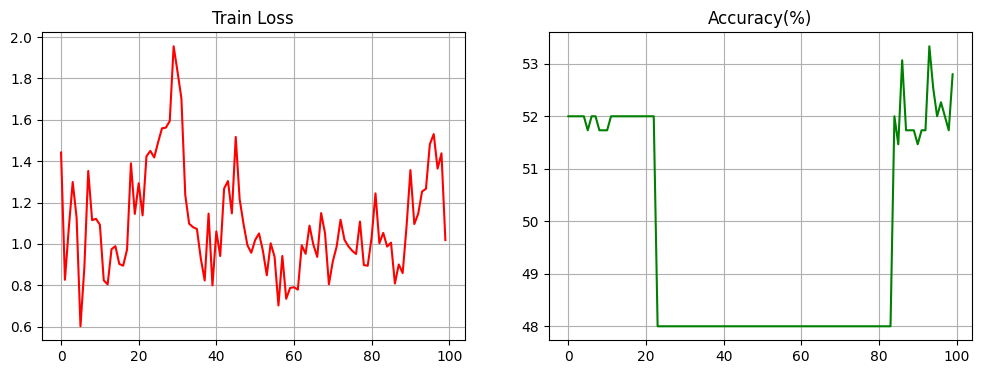

In [ ]:
epochs = 100
lr = 0.01 # learning rate
loss_opt = 'cross_entropy'

print(vqc.parameters)

loss_list, acc_list = vqc.train(train_loader, train_data, y_train, epochs, lr, loss_opt)

if (loss_list == None):
  print("Something went wrong with the training. Try again!")

print(vqc.parameters)

print_figs(loss_list, acc_list)

In [ ]:
y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

train_aver_glob_ent_list_2.append(round(train_aver, 3))
test_aver_glob_ent_list_2.append(round(test_aver, 3))
train_set_acc_list_2.append(round(accuracy_score(y_train, y_train_pred) * 100, 2))
test_set_acc_list_2.append(round(accuracy_score(y_test, y_test_pred) * 100, 2))

In [ ]:
ansatz = [[], [["Hadamard", 1], ["CNOT", 1, 0]]]

vqc = VariationalQuantumClassifier(qubits, encoding, ansatz, seed)
vqc.print()

y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

print("Train set accuracy: ", accuracy_score(y_train, y_train_pred) * 100, "%")
print("Train Global Entaglement average: ", train_aver)
print("Test set accuracy: ", accuracy_score(y_test, y_test_pred) * 100, "%")
print("Test Global Entaglement average: ", test_aver)


|0> --| RY |--| RZ |--| RY |--| RZ |---------+-
                                             ¦ 
|0> --| RY |--| RZ |--| RY |--| RZ |--| H |--●-

Train set accuracy:  40.8 %
Train Global Entaglement average:  0.20586590400000015
Test set accuracy:  41.6 %
Test Global Entaglement average:  0.17129363999999994


tensor([[0.1882, 1.8358, 3.3968],
        [0.4980, 2.2304, 1.3123]], dtype=torch.float64)


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

tensor([[-0.0641,  0.9837,  3.4017],
        [-1.4967,  1.5114,  0.3183]], dtype=torch.float64)


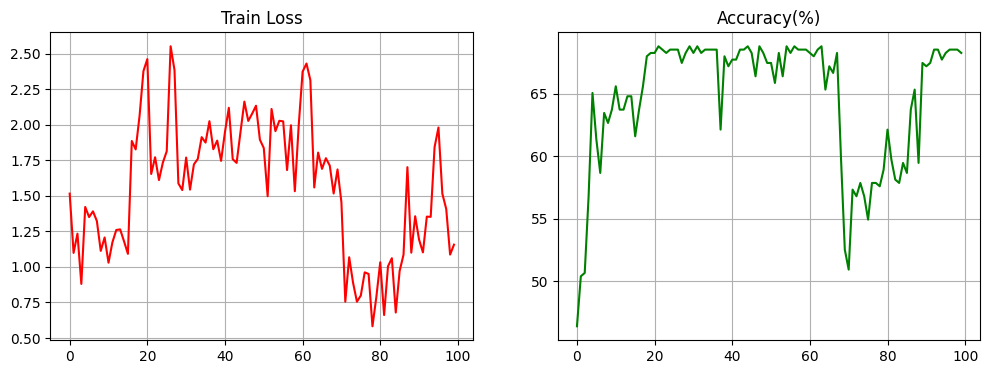

In [ ]:
epochs = 100
lr = 0.01 # learning rate
loss_opt = 'cross_entropy'

print(vqc.parameters)

loss_list, acc_list = vqc.train(train_loader, train_data, y_train, epochs, lr, loss_opt)

if (loss_list == None):
  print("Something went wrong with the training. Try again!")

print(vqc.parameters)

print_figs(loss_list, acc_list)

In [ ]:
y_train_pred = vqc.predict(train_data, cls)
train_aver, train_global_ent_list = vqc.global_entaglement_average()
y_test_pred = vqc.predict(test_data, cls)
test_aver, test_global_ent_list = vqc.global_entaglement_average()

train_aver_glob_ent_list_2.append(round(train_aver, 3))
test_aver_glob_ent_list_2.append(round(test_aver, 3))
train_set_acc_list_2.append(round(accuracy_score(y_train, y_train_pred) * 100, 2))
test_set_acc_list_2.append(round(accuracy_score(y_test, y_test_pred) * 100, 2))

Correlation between Average Global Entaglement and Accuracy for Concetric Circles dataset

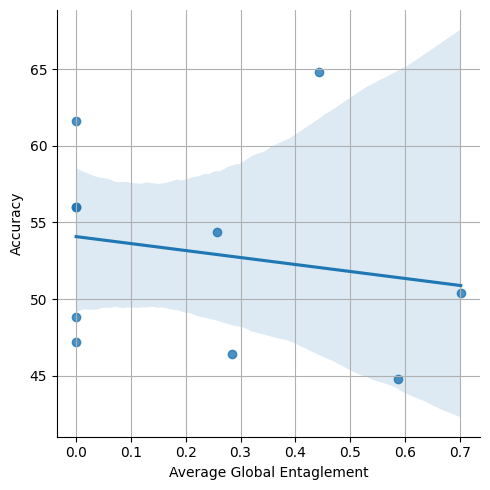

In [ ]:
my_array = np.array([test_aver_glob_ent_list_2, test_set_acc_list_2])

df = pd.DataFrame(np.transpose(my_array), columns=['Average Global Entaglement', 'Accuracy'])

# sns.scatterplot(x="Average Global Entaglement", y="Accuracy", data = df);
sns.lmplot(x="Average Global Entaglement", y="Accuracy", data = df);
plt.grid()
# plt.savefig("age_acc_2.svg")
plt.show()